# 0. Imports

In [1]:
import sys
import os
import pandas as pd

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))

import data_acquisition
import Dataframe
import feature_engineering
#import regression


In [2]:
os.environ['MY_VARIABLE'] = 'my_value'

# 1. Collecting Data

In [3]:
data_acquisition.collect_data()

The folder '../data/raw/2016_2017' already exists.
The folder '../data/raw/2017_2018' already exists.
The folder '../data/raw/2018_2019' already exists.
The folder '../data/raw/2019_2020' already exists.
The folder '../data/raw/2020_2021' already exists.


# 2. Cleaning Data

In [4]:
## environ 2 minutes

base_path = '../data/raw/'
df = Dataframe.load_all_seasons(base_path)
transformed_df = Dataframe.transformEventData(df)

Seasons: 100%|██████████| 5/5 [01:28<00:00, 17.73s/it]


## Ingénierie des caractéristiques 1

In [5]:
# Charger les données
data = pd.read_csv('../data/derivatives/dataframe.csv')
# Créer les nouvelles caractéristiques
feature_engineering.create_features1(data, '^201[6-9]02\d{4}$', 'features_train1.csv')

#  3. Modèles de base

In [6]:
# Set an environment variable
os.environ['api_key'] = "Bgx9192SVK3nzJNLQcV5nneQS"
os.environ['COMET_API_KEY'] = "Bgx9192SVK3nzJNLQcV5nneQS"

## Ingénierie des caractéristiques 2

In [7]:
transformed_df = feature_engineering.transformEventData(df)
transformed_df.to_csv('../data/derivatives/dataframe_milestone_2.csv', index=False)

In [10]:
dataframe_milestone_1 = pd.read_csv('../data/derivatives/dataframe.csv')
dataframe_milestone_2 = pd.read_csv('../data/derivatives/dataframe_milestone_2.csv')

data = feature_engineering.create_features2(dataframe_milestone_2,dataframe_milestone_1, pattern='^201[6-9]02\d{4}$')
data.to_csv('../data/derivatives/dataframe_milestone_2.csv', index=False)

## fusion des features de ingénierie des caractéristiques 1 et 2
engineering1 = pd.read_csv('../data/derivatives/features_train1.csv')
engineering2 = pd.read_csv('../data/derivatives/dataframe_milestone_2.csv')

data_final_train = feature_engineering.fusion_features(engineering1, engineering2)
data_final_train.to_csv('../data/derivatives/train_data.csv', index=False)

c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-A08\scripts\feature_engineering.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  angle = np.arctan((y_goal - y)/(x_goal - np.abs(x)))
c:\Users\lebou\Desktop\Cours_Canada\Data_science_IFT6758\project_nhl_data\ift6758-A08\scripts\feature_engineering.py:61: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arctan((y_goal - y)/(x_goal - np.abs(x)))


In [ ]:
# Question 5 :
feature_engineering.comet_log_dataframe_profile()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/me-pic/milestone-2/31d0d6097fcd49afbb290b72e9c04938

COMET WARNING: pandas_profiling is required to log profile; ignoring
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/me-pic/milestone-2/31d0d6097fcd49afbb290b72e9c04938
COMET INFO:   Others:
COMET INFO:     Name : Dataframe
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 

In [ ]:
# Séparation en un jeu de d'entrainement/test

# Filtre pour les saisons 2016/2017 et 2018/2019
train_data = data[(data['gameId'].astype(str).str.startswith('2016')) |
                  (data['gameId'].astype(str).str.startswith('2018'))]

# Filtre pour la saison 2019/2020
test_data = data[data['gameId'].astype(str).str.startswith('2019')]

train_data.to_csv('../data/derivatives/train_data.csv', index=False)
test_data.to_csv('../data/derivatives/test_data.csv', index=False)

# Modele de base

In [ ]:
import sys
import os
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, RocCurveDisplay, roc_auc_score , roc_curve, auc
from sklearn.calibration import CalibrationDisplay, calibration_curve

In [ ]:
data = pd.read_csv('../data/derivatives/features_train1.csv')

In [ ]:
X = data['distance_goal']
y = data['is_goal']
X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
        )

In [ ]:
# LogisticRegression prend des shape de (n,)
X_train = X_train.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
reshaped_X_val = X_val.values.reshape(-1,1)
reshaped_y_val = y_val.values.reshape(-1,1)

### Régression logistique entrainée sur la caractéristique 'Distance' uniquement

In [ ]:
clf = LogisticRegression().fit(X_train, y_train)

C:\Users\mathi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Précsion du model

In [ ]:
y_pred = clf.predict(reshaped_X_val)

# Calculer la précision du modèle
accuracy = accuracy_score(reshaped_y_val, y_pred)
print(accuracy)

0.9062459123610203


In [ ]:
y_score = clf.predict_proba(reshaped_X_val)
print(y_score)
# la première colonne est la probabilité que le model ne prédit pas un but pour la ligne d'entrée correspondante
# la deuxieme colonne est la probabilté que le model ne prédit un but pour la ligne d'entrée correspondante

[[0.96612945 0.03387055]
 [0.81085416 0.18914584]
 [0.81446129 0.18553871]
 ...
 [0.8002089  0.1997911 ]
 [0.89720899 0.10279101]
 [0.91438653 0.08561347]]


In [ ]:
# on s'intéresse à la deuxième colonne y_score[:,1] qui représente la probabilité de prédire un but

# Receiver Operating Characteristic
ROC_plot(y_val, y_score[:,1])

# Taux de buts
Centiles_plot(y_val, y_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y_val, y_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(clf,reshaped_X_val, reshaped_y_val, n_bins=50)

TypeError: ROC_plot() missing 1 required positional argument: 'model'

### Régression logisrique entrainnée sur la caractéristique 'Angle' uniquement

In [ ]:
X_1 = data['angle_goal']
X1_train, X1_val, y1_train, y1_val = train_test_split(
        X_1, y, test_size=0.2, random_state=42
        )

X1_train = X1_train.values.reshape(-1,1)
y1_train = y1_train.values.reshape(-1,1)
reshaped_X1_val = X1_val.values.reshape(-1,1)
reshaped_y1_val = y1_val.values.reshape(-1,1)

clf_1 = LogisticRegression().fit(X1_train, y1_train)

y1_score = clf_1.predict_proba(reshaped_X1_val)

KeyError: 'angle_goal'

AUC metric : 0.5020579700966246


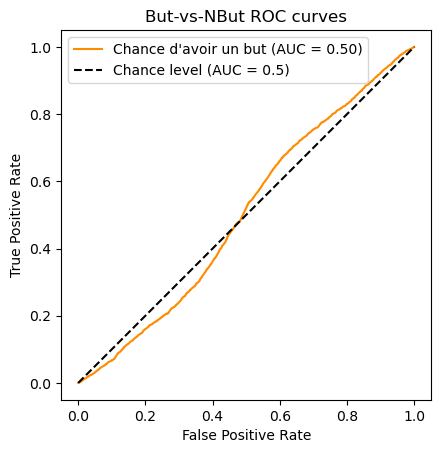

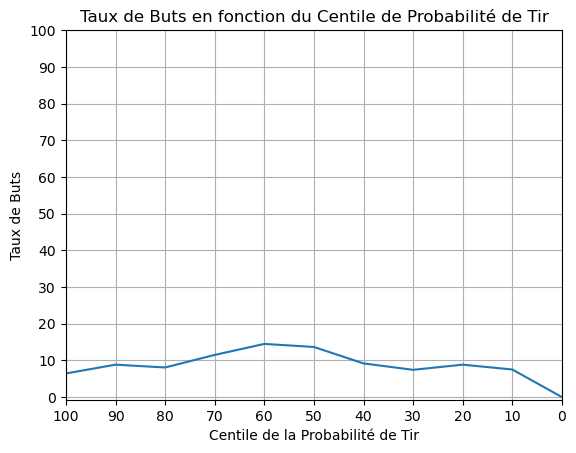

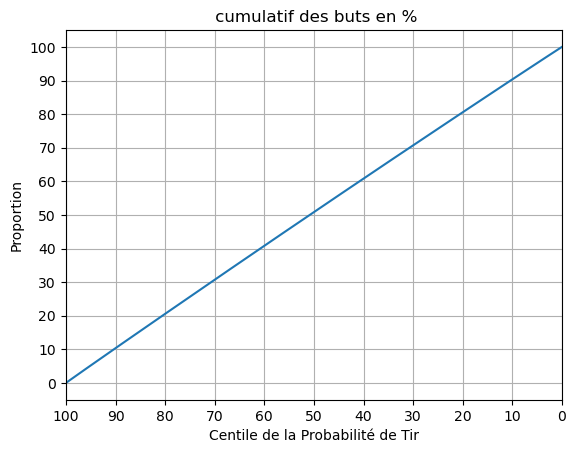

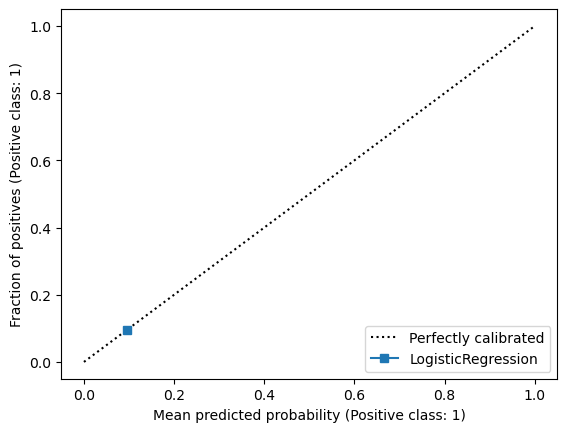

In [ ]:
# Receiver Operating Characteristic
ROC_plot (y1_val, y1_score[:,1])

# Taux de buts
Centiles_plot(y1_val, y1_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y1_val, y1_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(clf_1,reshaped_X1_val, reshaped_y1_val, n_bins=50)

### Régression logistique entrainée sur les caractéristique 'distance' et 'Angle'

In [ ]:
X_2 = data[['distance_goal','angle_goal']]
X2_train, X2_val, y2_train, y2_val = train_test_split(
        X_2, y, test_size=0.2, random_state=42
        )
y2_train = y2_train.values.reshape(-1,1)
reshaped_y2_val = y2_val.values.reshape(-1,1)
clf_2 = LogisticRegression().fit(X2_train, y2_train)
y2_score = clf_2.predict_proba(X2_val)

C:\Users\mathi\miniconda3\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC metric : 0.6964502052410217


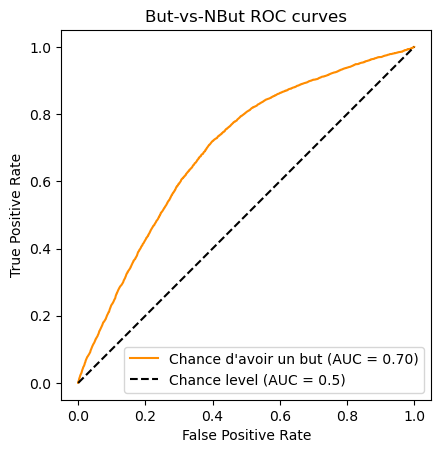

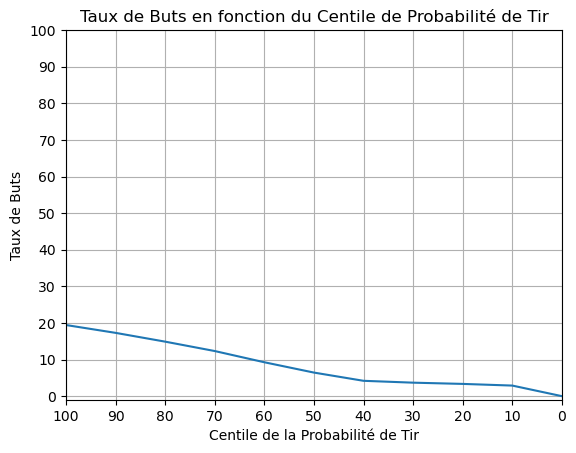

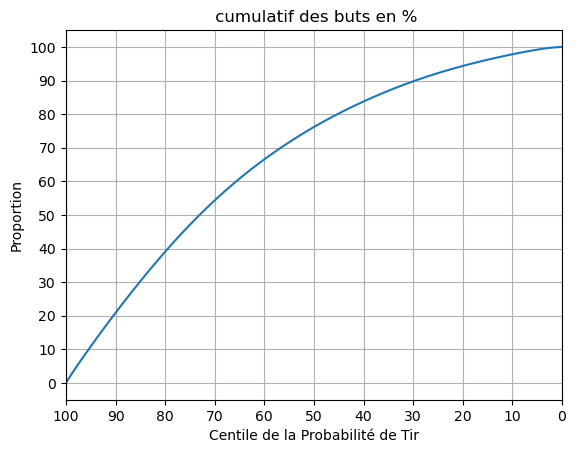

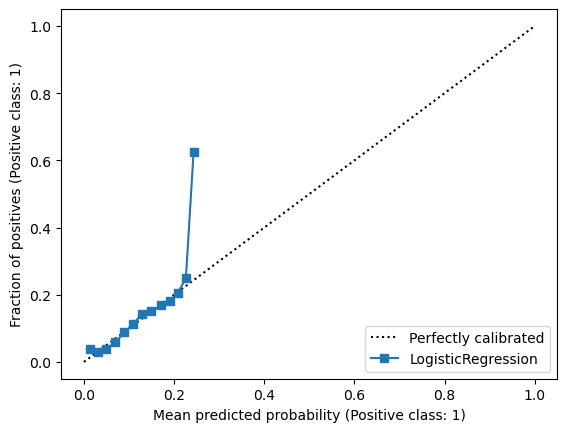

In [ ]:
# Receiver Operating Characteristic
ROC_plot (y2_val, y2_score[:,1])

#Taux de buts
Centiles_plot(y2_val, y2_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y2_val, y2_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_estimator(clf_2,X2_val, reshaped_y2_val, n_bins=50)

### Régression logistique avec échantillonage uniforme

AUC metric : 0.4953581525399408


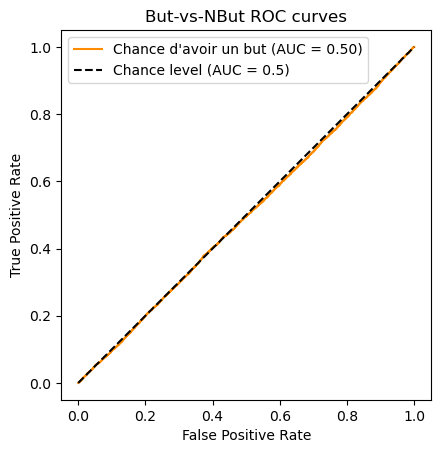

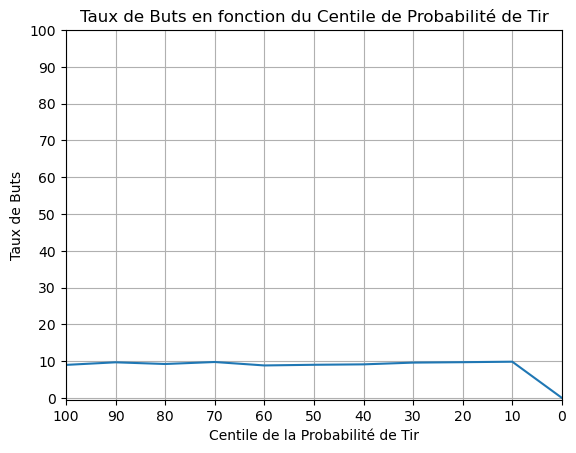

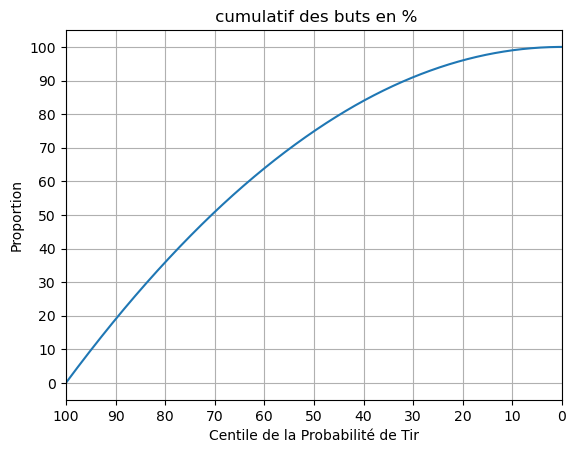

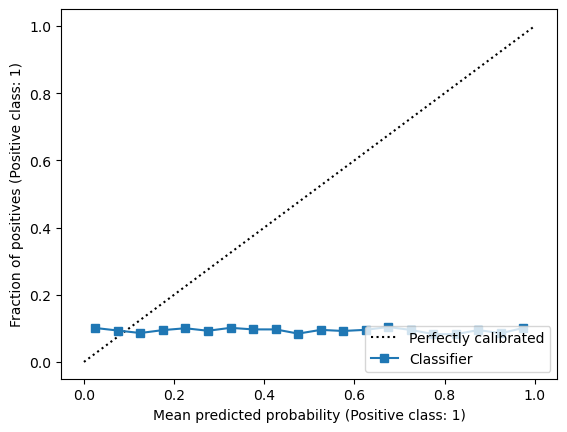

In [ ]:
# Échantillonnage des probabilités prédites à partir d'une distribution uniforme U(0, 1)

y_uniform_sampled = np.random.uniform(0, 1, len(y2_score[:,1]))

# Receiver Operating Characteristic
ROC_plot (y2_val, y_uniform_sampled)

#Taux de buts
Centiles_plot(y2_val, y_uniform_sampled)

# Cumule de buts
cumulative_centiles_plot(y2_val, y_uniform_sampled)

# Courbe de calibration
CalibrationDisplay.from_predictions(y2_val, y_uniform_sampled, n_bins=20)

# Ingénierie des caractéristiques II

In [ ]:
from comet_ml import Experiment
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scripts.Basic_model import *

In [ ]:
data = pd.read_csv('../data/derivatives/train_data.csv')

In [ ]:
experiment = Experiment(
    api_key="Bgx9192SVK3nzJNLQcV5nneQS",
    project_name="milestone-2",
    workspace="me-pic"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/me-pic/milestone-2/471182d5fcdc48769146c280e1d8b0e7



### Setting label

In [ ]:
X = data[['distance_from_last_event', 'changement_angle_tir']]
y = data['goalFlag']

### Splitting Data train / Val (80-20)

In [ ]:
# On split 80 / 20 les donnees
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Training xgboost

In [ ]:
xgboost_classifier = xgb.XGBClassifier()
xgboost_classifier.fit(X_train, y_train)

y_pred_proba = xgboost_classifier.predict_proba(X_test)[:, 1]

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

### Calculating ROC

ROC AUC Score: 0.5735962878368401


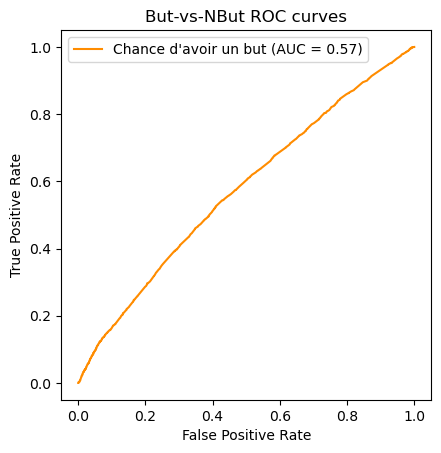

AUC metric : 0.5735962878368401


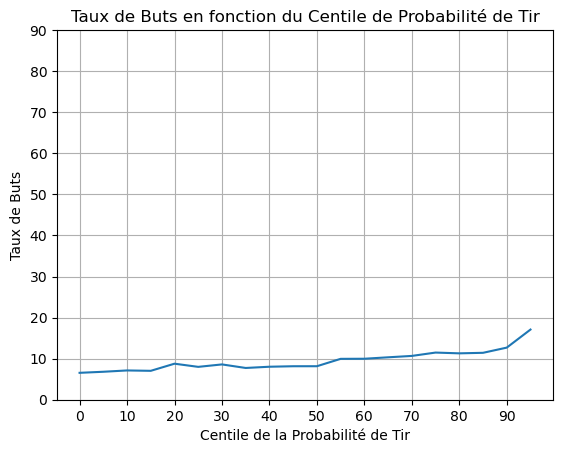

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


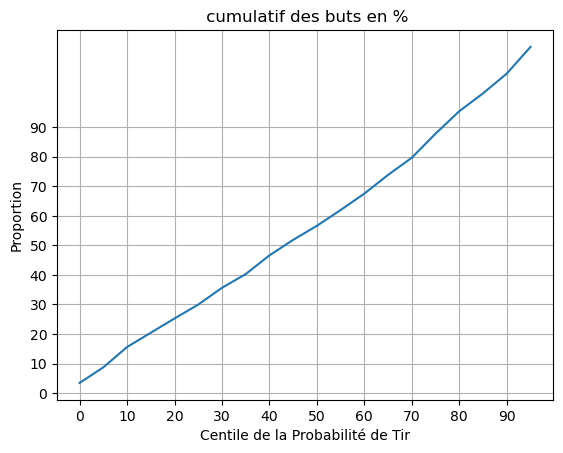

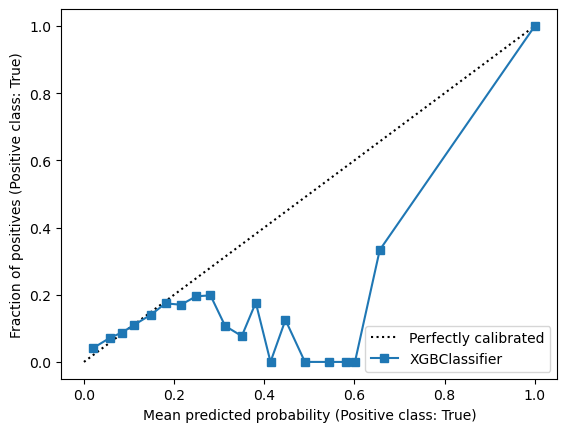

In [ ]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC_plot(y_test, y_pred_proba)

#Taux de buts
Centiles_plot(y_test, y_pred_proba)

# Cumule de buts
cumulative_centiles_plot(y_test, y_pred_proba)

# Calibration display
reshaped_X1_val = X_test.values.reshape(-1,1)
reshaped_y1_val = y_train.values.reshape(-1,1)
calibrate_display(xgboost_classifier, X_test, y_test, 30)

### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune and their possible values
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create the GridSearchCV object with cross-validation (e.g., 5-fold cross-validation)
grid_search = GridSearchCV(
    estimator=xgboost_classifier,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5
)

print("Training with the Grid Search")
# We train with the Grid Search
grid_search.fit(X_train, y_train)

# We output the best parameters that were given
print("Output the best hyperparams")
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Training with the Grid Search


C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

Output the best hyperparams
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


ROC AUC Score: 0.5838184167253935


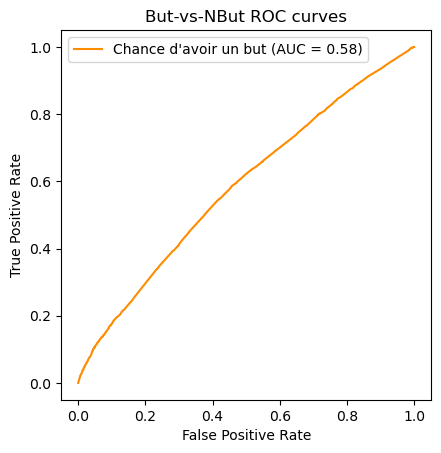

AUC metric : 0.5838184167253935


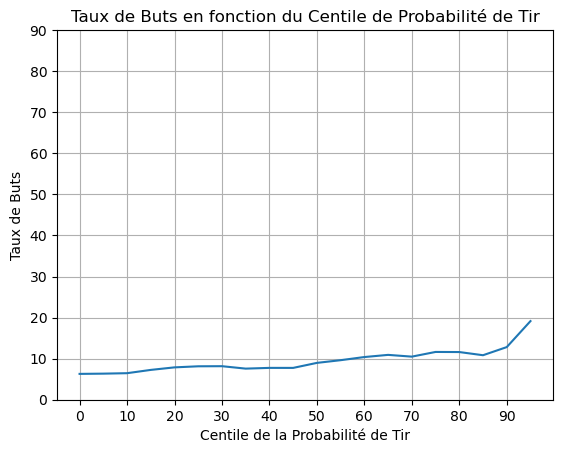

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
COMET E

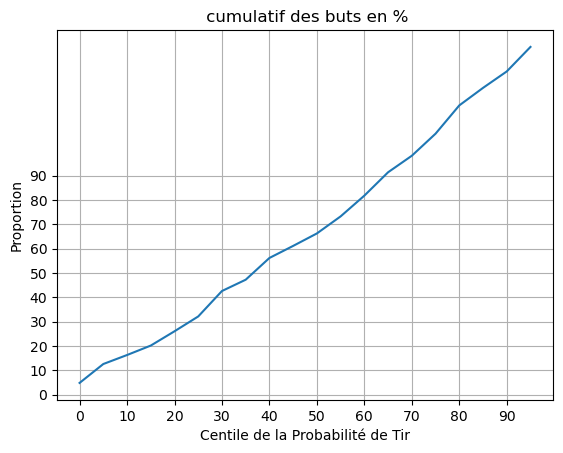

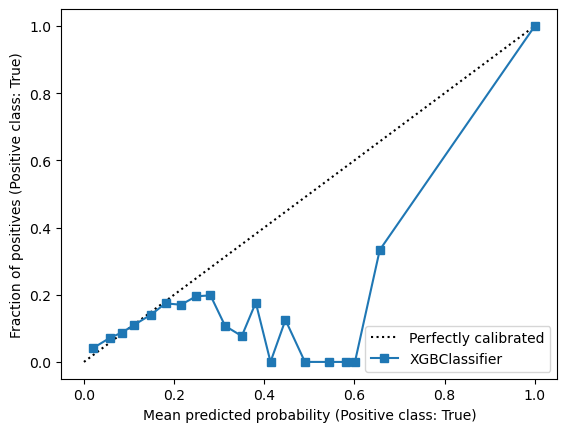

In [ ]:
# We retrain the model with the new parameters
best_xgboost_classifier = grid_search.best_estimator_
y_pred_proba = best_xgboost_classifier.predict_proba(X_test)[:, 1]

# We evaluate once again
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC_plot(y_test, y_pred_proba)

#Taux de buts
Centiles_plot(y_test, y_pred_proba)

# Cumule de buts
cumulative_centiles_plot(y_test, y_pred_proba)

# Calibration display
calibrate_display(xgboost_classifier, X_test, y_test, 30)

experiment.log_parameter("learning_rate", best_xgboost_classifier.learning_rate)
experiment.log_parameter("max_depth", best_xgboost_classifier.max_depth)
experiment.log_parameter("n_estimator", best_xgboost_classifier.n_estimators)

experiment.log_metric("SOC", roc_auc)

experiment.log_model("best_xgboost_classifier", best_xgboost_classifier)

### Feature Selection

In [ ]:
# XGBoost has a L1 regularization term that we can use to identify features that are assigned the 0 weight

xgboost_classifier = xgb.XGBClassifier(learning_rate=best_xgboost_classifier.learning_rate, n_estimators=best_xgboost_classifier.n_estimators, max_depth=best_xgboost_classifier.max_depth, reg_alpha=1)  # Add reg_alpha for L1 regularization
xgboost_classifier.fit(X_train, y_train)

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Test After Feature selection

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


ROC AUC Score: 0.5836028893587033


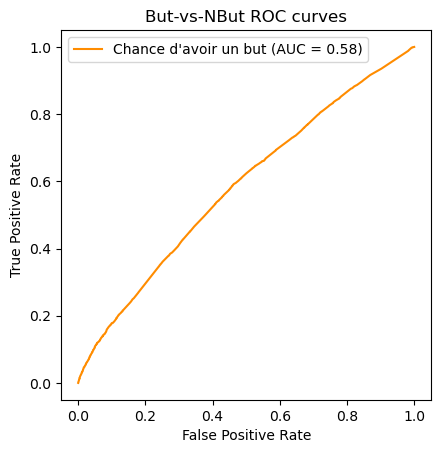

AUC metric : 0.5836028893587033


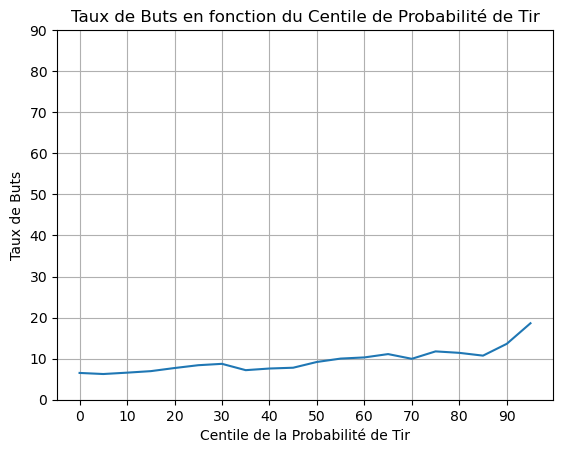

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


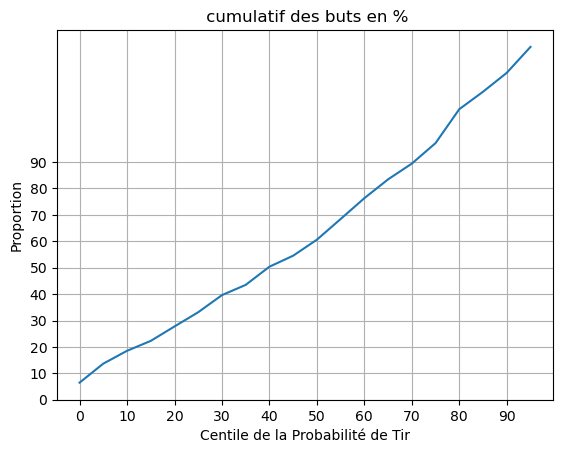

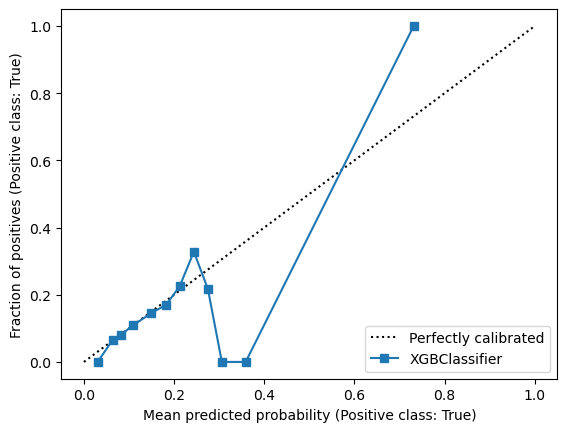

In [ ]:
y_pred_proba = xgboost_classifier.predict_proba(X_test)[:, 1]

# We evaluate once again
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc}")

ROC_plot(y_test, y_pred_proba)

#Taux de buts
Centiles_plot(y_test, y_pred_proba)

# Cumule de buts
cumulative_centiles_plot(y_test, y_pred_proba)

# Calibration display
calibrate_display(xgboost_classifier, X_test, y_test, 30)

experiment.log_parameter("learning_rate", best_xgboost_classifier.learning_rate)
experiment.log_parameter("max_depth", best_xgboost_classifier.max_depth)
experiment.log_parameter("n_estimator", best_xgboost_classifier.n_estimators)

experiment.log_metric("SOC", roc_auc)

In [ ]:
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
from scripts import Advanced_model

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/me-pic/milestone-2/471182d5fcdc48769146c280e1d8b0e7
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (801.10 KB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: As you are running in a Jupyter

ROC AUC Score: 0.5875909831654296


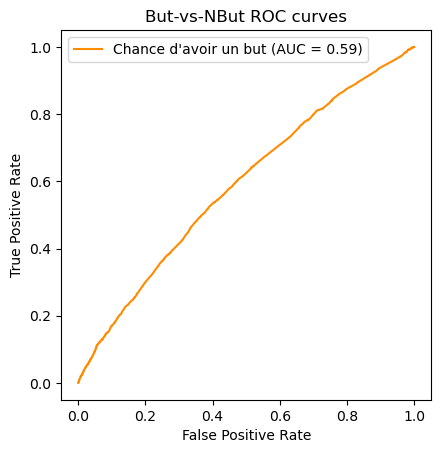

AUC metric : 0.5875909831654296


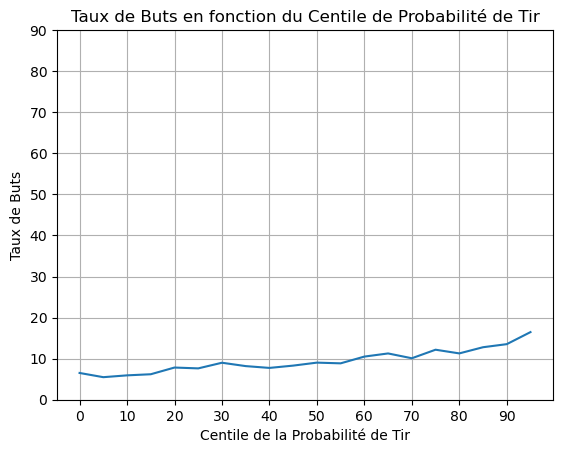

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

Training with the Grid Search


C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
C:\User

Output the best hyperparams
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
ROC AUC Score: 0.5917515722759009


C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


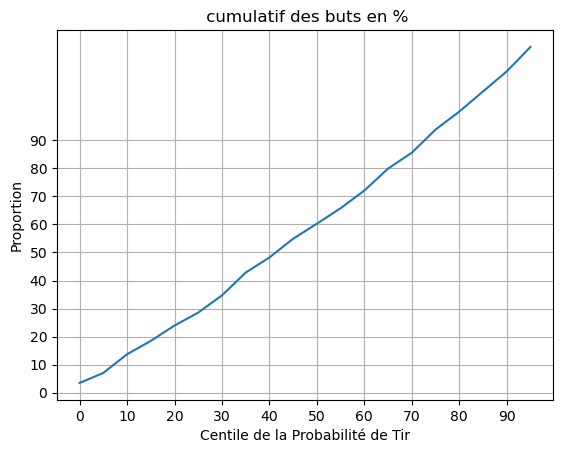

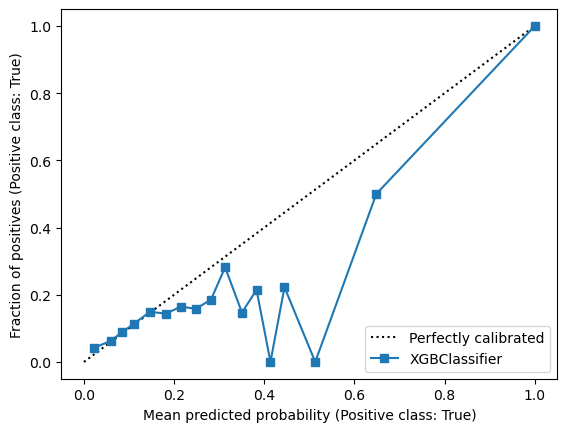

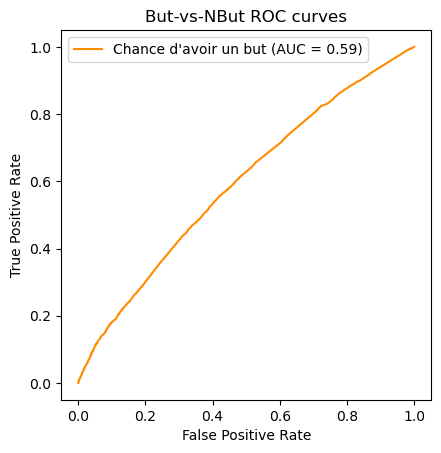

AUC metric : 0.5917515722759009


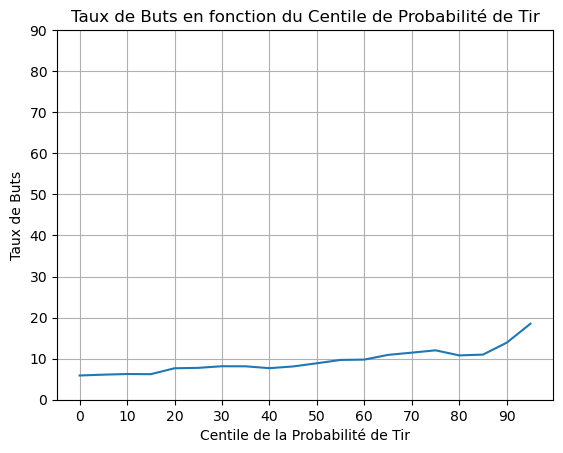

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
COMET E

ROC AUC Score: 0.5909987314975539


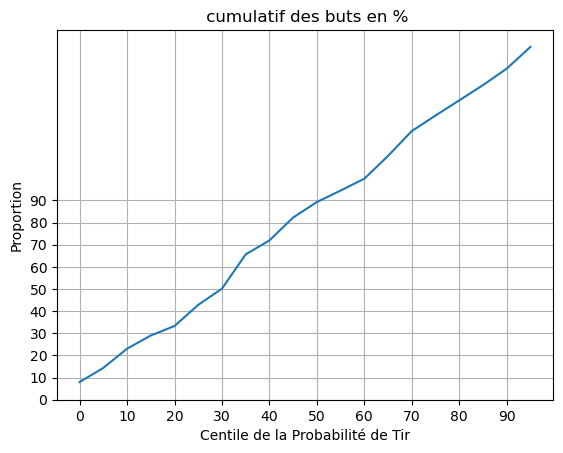

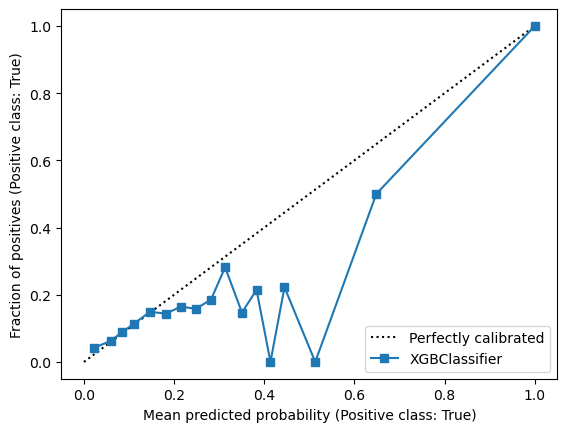

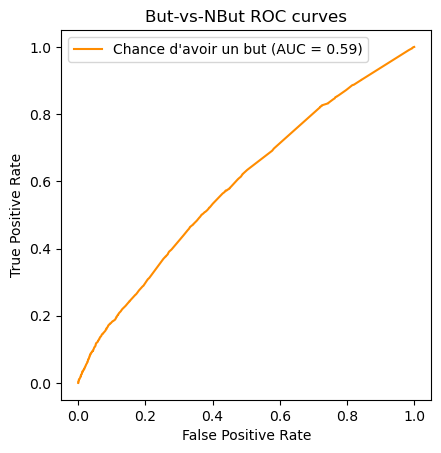

AUC metric : 0.5909987314975539


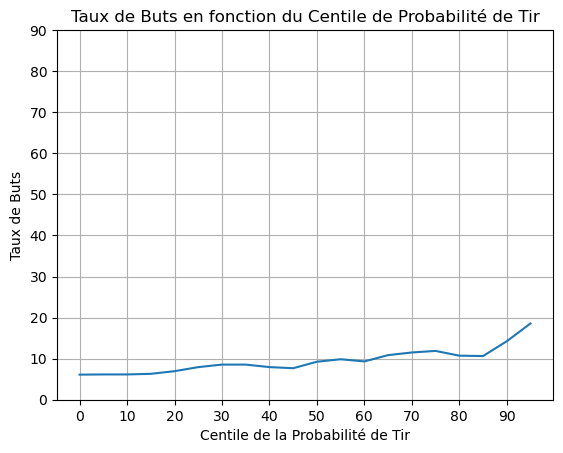

C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\mathi\miniconda3\Lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


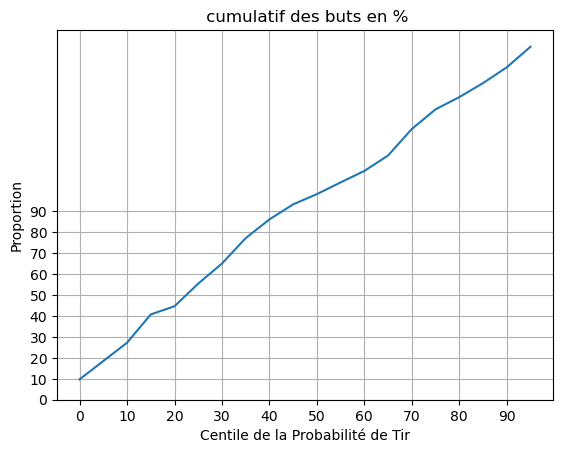

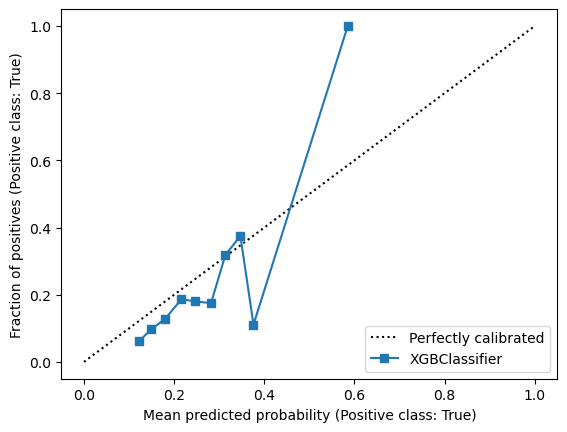

In [ ]:
Advanced_model.xgboost()

# Faites de votre mieux!

### Random Forest

In [ ]:
import sys
import os
from comet_ml import Experiment
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, average_precision_score
from sklearn.model_selection import RandomizedSearchCV

current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))


from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot
from feature_engineering import preprocessing

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/me-pic/milestone-2/686eadf67ad74c7f8087d42150b6f552
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     SOC [2] : (0.5836028893587033, 0.5838184167253935)
COMET INFO:   Parameters:
COMET INFO:     learning_rate : 0.1
COMET INFO:     max_depth     : 5
COMET INFO:     n_estimator   : 50
COMET INFO:     objective     : binary:logistic
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     en

AUC metric : 0.7495498002567366


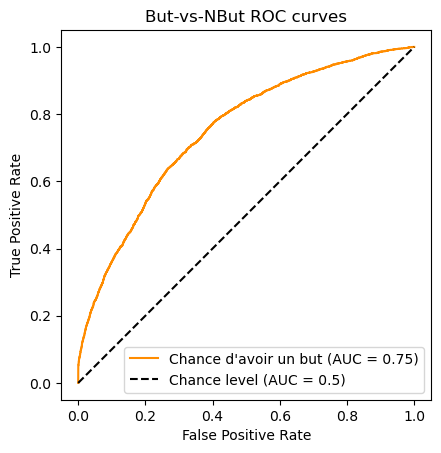

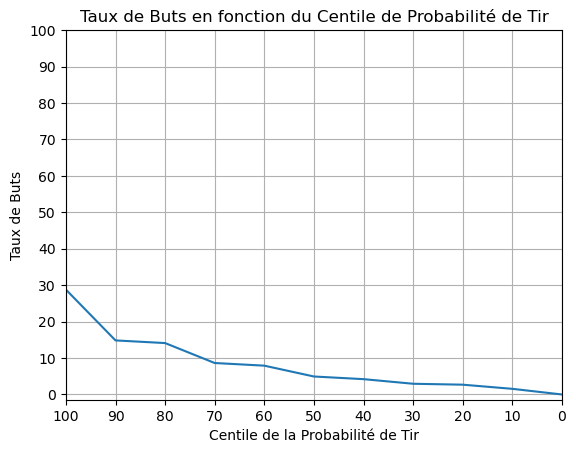

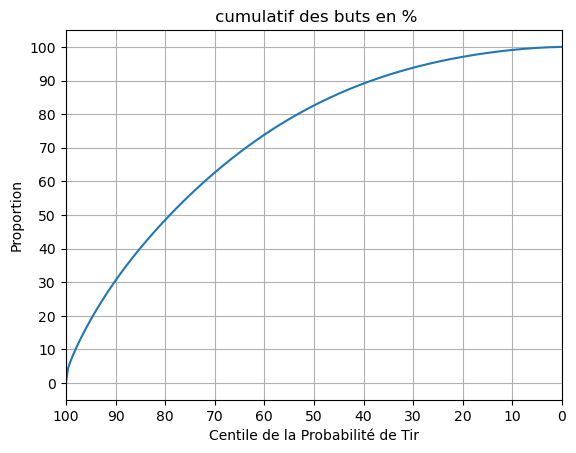

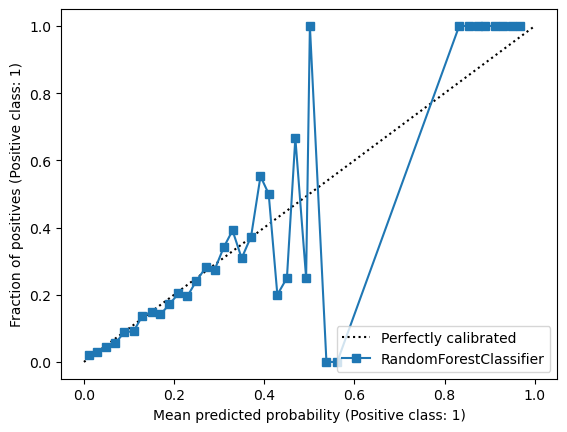

In [ ]:
class CometExperiment:

    def __init__(self, path, artifact_name, api_key, project_name, workspace):
        self.path = path
        self.artifact_name = artifact_name
        self.api_key = "Bgx9192SVK3nzJNLQcV5nneQS"
        self.project_name = project_name
        self.workspace = workspace

    def read_data(self):
        df = pd.read_csv(self.path)
        X, y = preprocessing(df, 'goalFlag')

        result = train_test_split(X, y, test_size=0.2, random_state=42)

        return result

    def compute_metrics(self, y_test, y_probs):

        # Create dictionary called metrics to store all metrics
        metrics = {}
        metrics["roc_auc"] = roc_auc_score(y_test, y_probs[:, 1])
        metrics["average_precision"] = average_precision_score(y_test, y_probs[:, 1])
        metrics["log_loss"] = log_loss(y_test, y_probs)
        metrics["brier_score"] = brier_score_loss(y_test, y_probs[:, 1])

        return metrics

    def run_experiment(self, param_dist, model_name, n_iter=10, cv=3):

        #Instantiate the Experiment Object from comet
        experiment = Experiment(
            api_key=self.api_key,
            project_name= self.project_name,
            workspace= self.workspace)

        # Set the name of the experiment to be that of the model name passed
        experiment.set_name(model_name)
        experiment.add_tag(model_name)


        #Get the train and test data from read_data function
        X_train, X_test, y_train, y_test = self.read_data()

        model = RandomForestClassifier()
        randomized_search = RandomizedSearchCV(model, param_dist, n_iter=n_iter, cv=cv, scoring='accuracy', random_state=42)



        with experiment.train():

            randomized_search.fit(X_train, y_train)
            best_model = randomized_search.best_estimator_

            # Log les meilleurs hyperparamètres et la meilleure performance
            experiment.log_parameters(randomized_search.best_params_)
            experiment.log_metric("best_score", randomized_search.best_score_)

            y_probs = best_model.predict_proba(X_test)
            # Compute the mertrics
            metrics = self.compute_metrics(y_test, y_probs)

            #Log metrics to comet
            experiment.log_metrics(metrics)


        with experiment.validate():
            #Logs the text message to comet
            experiment.log_text("This is the Evaluation Metrics for the Validation Set")
            y_probs = best_model.predict_proba(X_test)

            #Compute metrics
            metrics = self.compute_metrics(y_test, y_probs)

            #Log metrics to comet
            experiment.log_metrics(metrics)


        experiment.log_model(name="Random Forest", file_or_folder='../notebooks/Random_Forest_model.ipynb')
        experiment.end()

        y_test = pd.Series(y_test)

        self.visualisation(best_model, y_probs, y_test, X_test)

    def visualisation(self, best_model, y_probs, y_test, X_test):
        ROC_plot(y_test, y_probs[:, 1])
        Centiles_plot(y_test, y_probs[:, 1])
        cumulative_centiles_plot(y_test, y_probs[:, 1])

        CalibrationDisplay.from_estimator(best_model, X_test, y_test, n_bins=50)

if __name__ == "__main__":
    API_KEY = os.environ.get('COMET_API_KEY')
    project_name = "milestone-2"
    workspace = "me-pic"

    path = "../data/derivatives/train_data.csv"
    artifact_name = "train_data"

   #Initialize the Object
    project = CometExperiment(path, artifact_name, API_KEY, project_name, workspace)

    # Défininition de l'espace des hyperparamètres
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    #Pass in the model and it's name
    project.run_experiment(param_grid, "Random Forest")

### Neural Network

In [ ]:
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
from scripts import model_nn_clf
from scripts import histGB

ModuleNotFoundError: No module named 'torch'

In [ ]:
model_nn_clf.RunANN()